##### 4.实际应用（New Haven治安事件）
数据准备：加载GISTools中的newhaven数据集，包含街区边界（blocks）和事件点（breach）。
- 核密度实现：

载入数据

In [45]:
load('C:/Users/thinkpad/Desktop/Data_analysis_courses/scripts/R-SpatialAnalysis/ppa.RData')

数据对象由三个空间数据层组成：
- starbucks：位于马萨诸塞州的星巴克门店的ppp点层；
- ma：马萨诸塞边界的多边形层；
- pop：人口密度分布的栅格层。所有层都采用spatstat包支持的格式（Baddeley, Rubak, and Turner 2016）。

#### 数据准备

本教程中使用的所有点模式分析工具都可以在spatstat包中获得。
这些工具被设计用于处理存储为ppp对象的点，而不是SpatialPointsDataFrame或sf对象。注意，ppp对象可能有也可能没有属性信息（也称为标记）。
如果要成功完成操作，了解函数是否需要在ppp对象中存在属性表是很重要的。

In [46]:
library(spatstat)
marks(starbucks)  <- NULL

许多点模式分析，如平均最近邻分析，应该明确定义它们的研究边界。这可以在 spatstat 中通过使用 Window（）函数将马萨诸塞州边界多边形 “绑定” 到星巴克点特征对象来完成。

In [47]:
Window(starbucks) <- ma

绘图

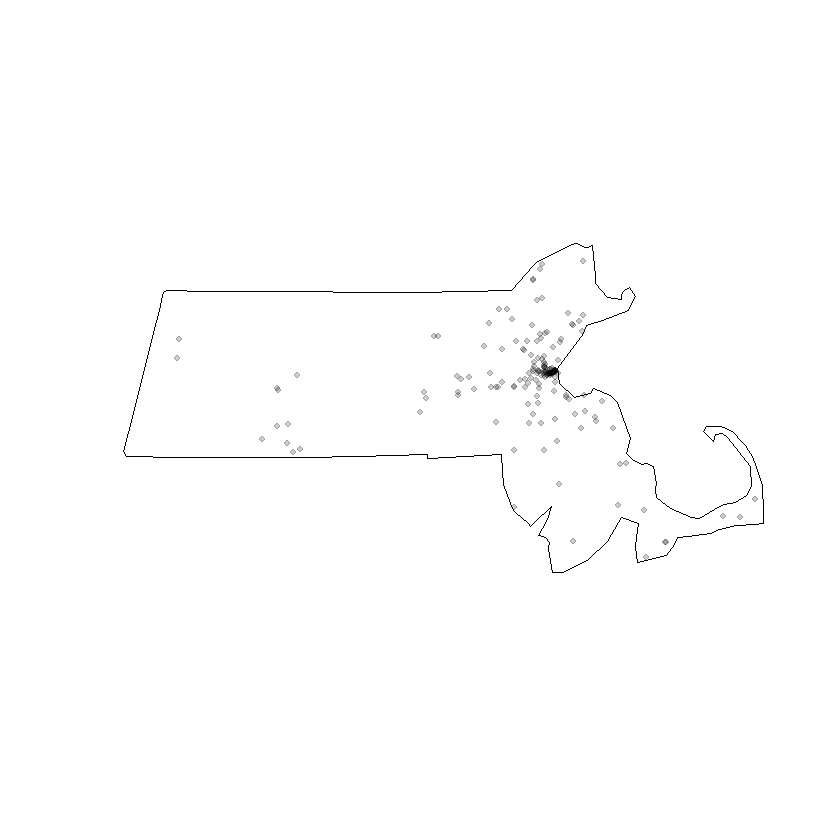

In [48]:
plot(starbucks, main=NULL, cols=rgb(0,0,0,.2), pch=20)

我们将对数据集进行另一项更改。行政区划的人口密度值通常相当偏斜。马萨诸塞州的人口密度也不例外。以下代码块从人口栅格层生成直方图。

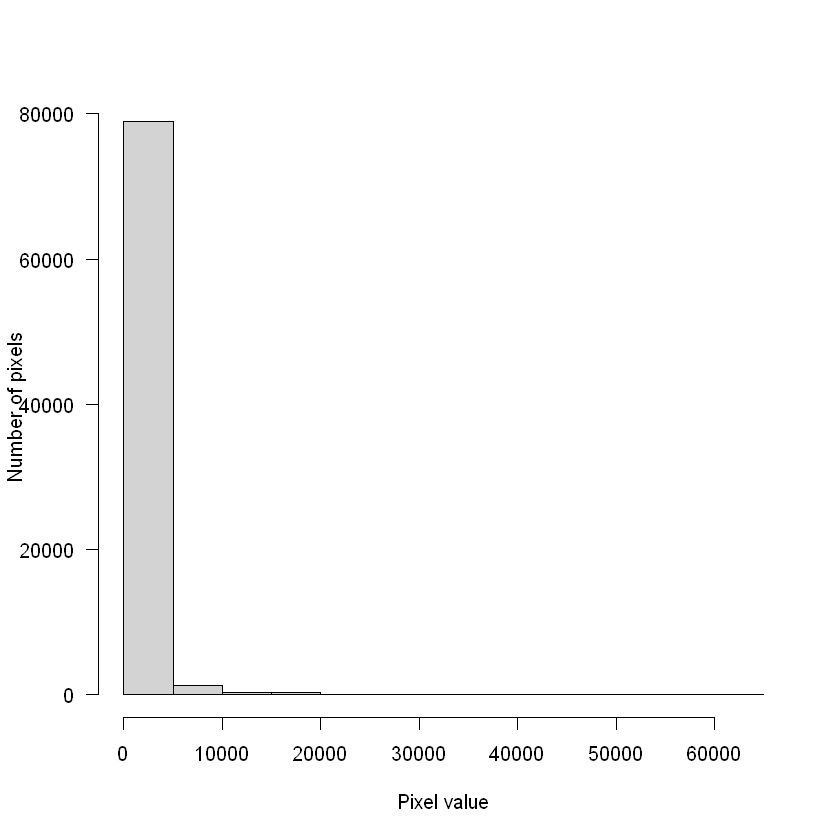

In [49]:
hist(pop, main=NULL, las=1)

将人口密度协变量的偏态分布进行转换，可能有助于揭示点分布与协变量之间的一些关系，这些关系将在本教程后面涵盖的某些点模式分析中体现。因此，我们将创建人口密度的对数转换版本。

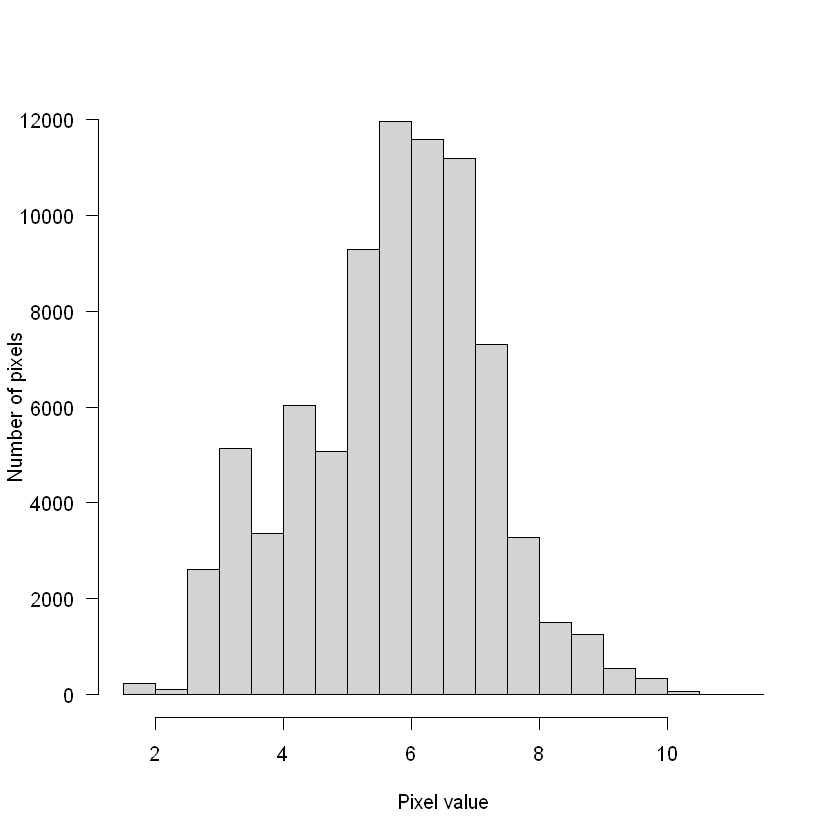

In [50]:
pop.lg <- log(pop)
hist(pop.lg, main=NULL, las=1)

### 基于密度的分析

#### 1. 样方密度（Quadrat density）
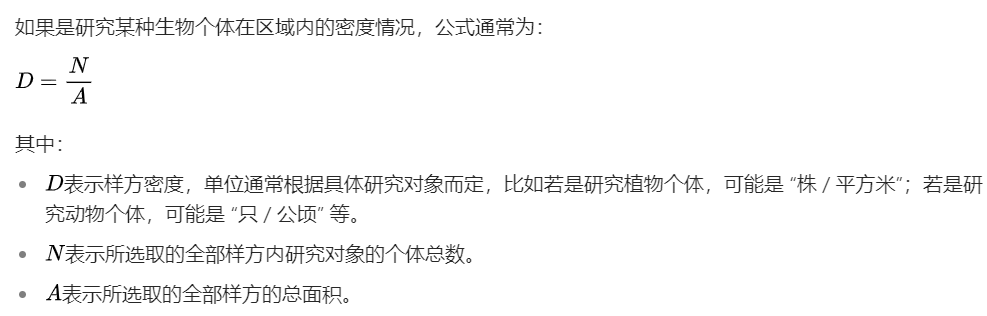


In [51]:
Q <- quadratcount(starbucks, nx= 6, ny=3)

对象Q存储每个象限内的点数。你可以将这些象限与计数一起绘制如下：

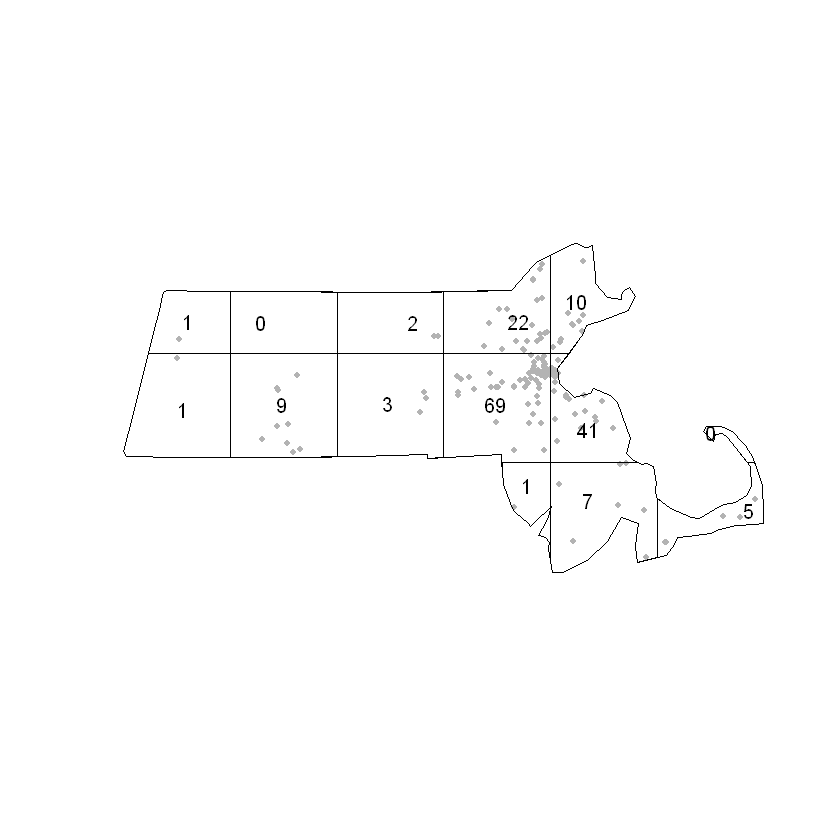

In [52]:
plot(starbucks, pch=20, cols="grey70", main=NULL)  # Plot points
plot(Q, add=TRUE)  # Add quadrat grid

你可以计算每个样方内的点密度如下

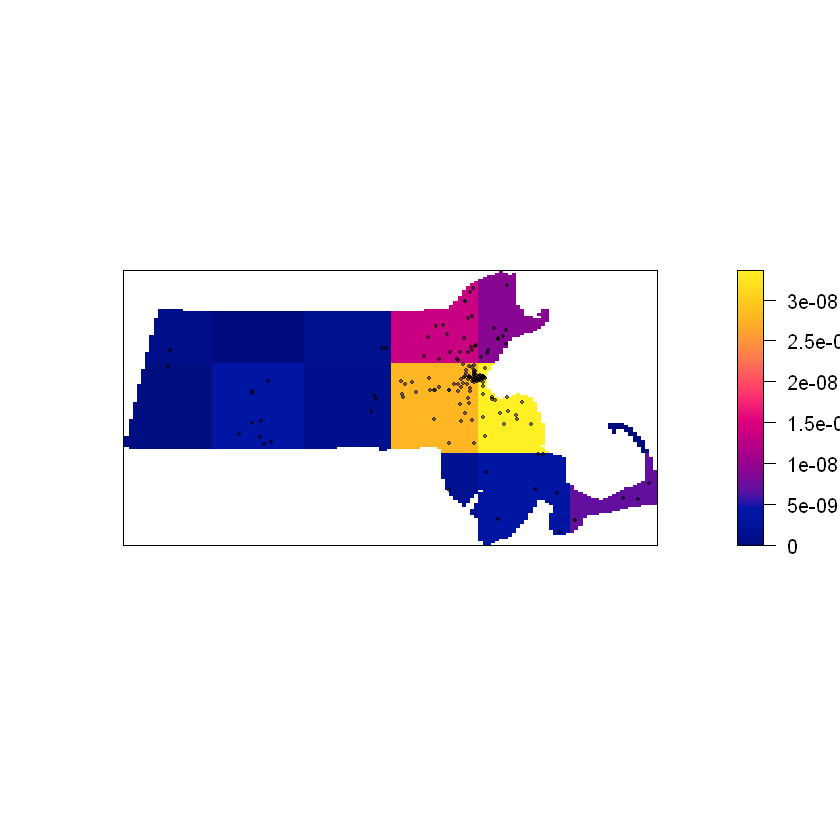

In [54]:
# Compute the density for each quadrat
Q.d <- intensity(Q)

# Plot the density
plot(intensity(Q, image=TRUE), main=NULL, las=1)  # Plot density raster
plot(starbucks, pch=20, cex=0.6, col=rgb(0,0,0,.5), add=TRUE)  # Add points

密度值报告为每平方米、每平方的点数（存储）。长度维度单位是从与点层关联的坐标系中提取的。在本例中，长度单位以米为单位，因此密度报告为每平方米的点。在这种分析规模下，如此小的长度单位是不实用的。因此，希望将空间对象重新缩放为更大的长度单位，例如公里。

In [55]:
starbucks.km <- rescale(starbucks, 1000, "km")
ma.km <- rescale(ma, 1000, "km")
pop.km    <- rescale(pop, 1000, "km")
pop.lg.km <- rescale(pop.lg, 1000, "km")

rescale函数的第二个参数将当前单位（米）转换为新单位（千米）。这为我们提供了更合理的密度值来处理。

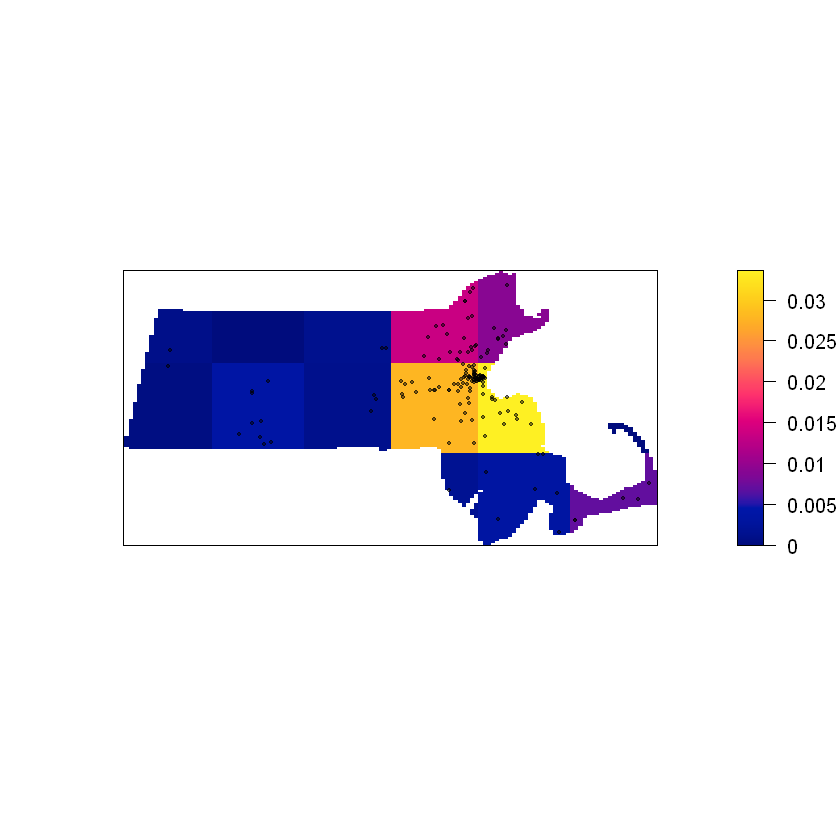

In [56]:
# Compute the density for each quadrat (in counts per km2)
Q   <- quadratcount(starbucks.km, nx= 6, ny=3)
Q.d <- intensity(Q)

# Plot the density
plot(intensity(Q, image=TRUE), main=NULL, las=1)  # Plot density raster
plot(starbucks.km, pch=20, cex=0.6, col=rgb(0,0,0,.5), add=TRUE)  # Add points

#### 镶嵌曲面上的样方密度

我们可以使用诸如人口密度栅格之类的协变量来定义非均匀方块。我们将首先按照等间隔分类方案将人口密度协变量划分为四个区域（又名镶嵌曲面）。回想一下，我们正在使用对数转换的人口密度值。休息时间将定义如下：

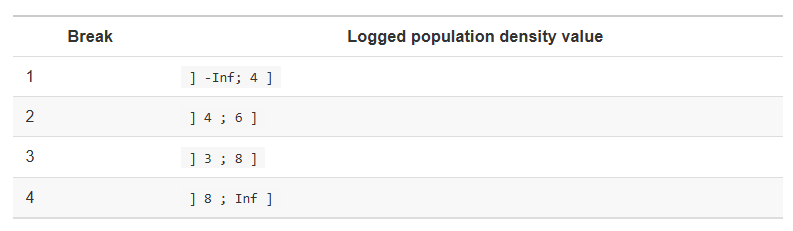

In [57]:
brk  <- c( -Inf, 4, 6, 8 , Inf)  # Define the breaks
Zcut <- cut(pop.lg.km, breaks=brk, labels=1:4)  # Classify the raster
E    <- tess(image=Zcut)  # Create a tesselated surface

可以映射镶嵌对象以查看象限的空间分布。

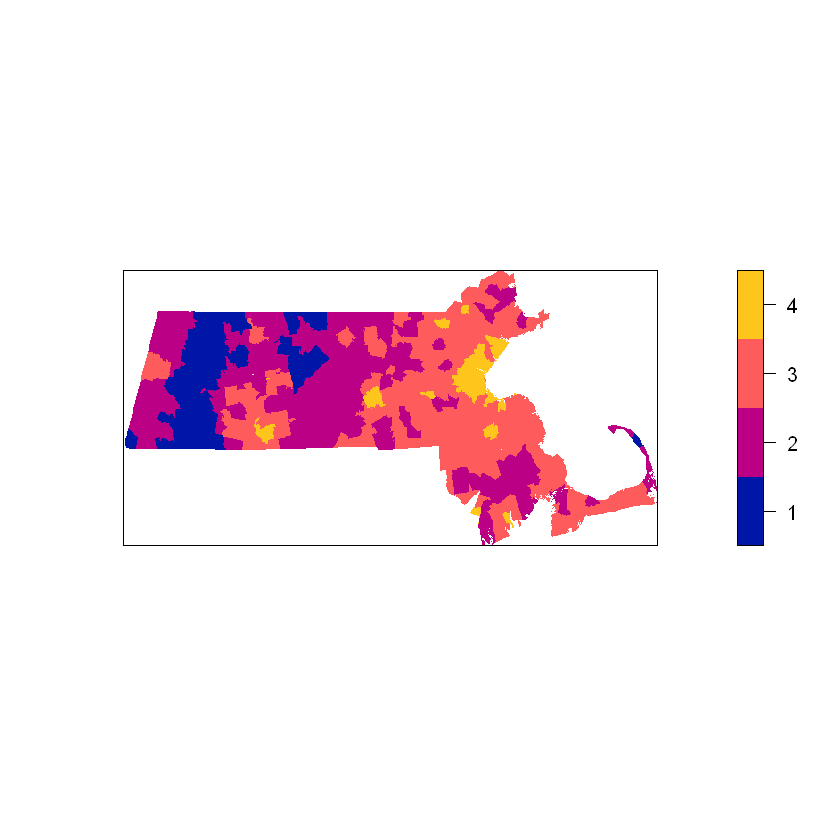

In [58]:
plot(E, main="", las=1)

接下来，我们将在每个镶嵌区域内计算方块计数，然后计算它们的密度值（每个方块区域的点数）。

In [59]:
Q   <- quadratcount(starbucks.km, tess = E)  # Tally counts
Q.d <- intensity(Q)  # Compute density
Q.d

tile
           1            2            3            4 
0.0000000000 0.0003706106 0.0103132964 0.0889370933 

回想一下，长度单位是公里，因此上面的密度值是每个样方单位内每平方公里的点数。绘制每个镶嵌区域的密度值。

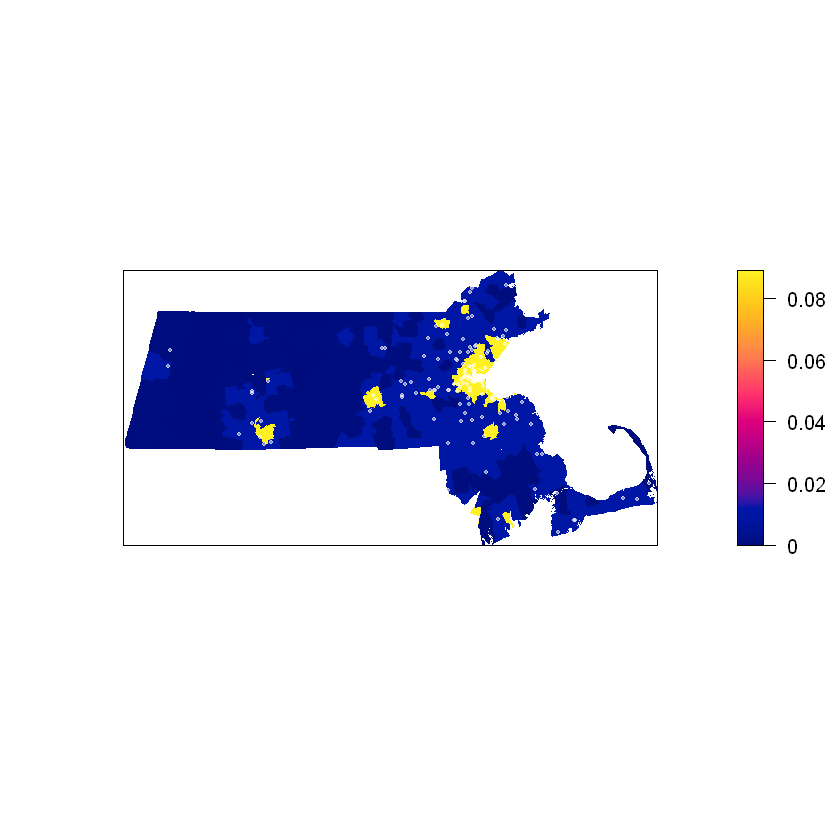

In [60]:
plot(intensity(Q, image=TRUE), las=1, main=NULL)
plot(starbucks.km, pch=20, cex=0.6, col=rgb(1,1,1,.5), add=TRUE)

修改一下配色方案。

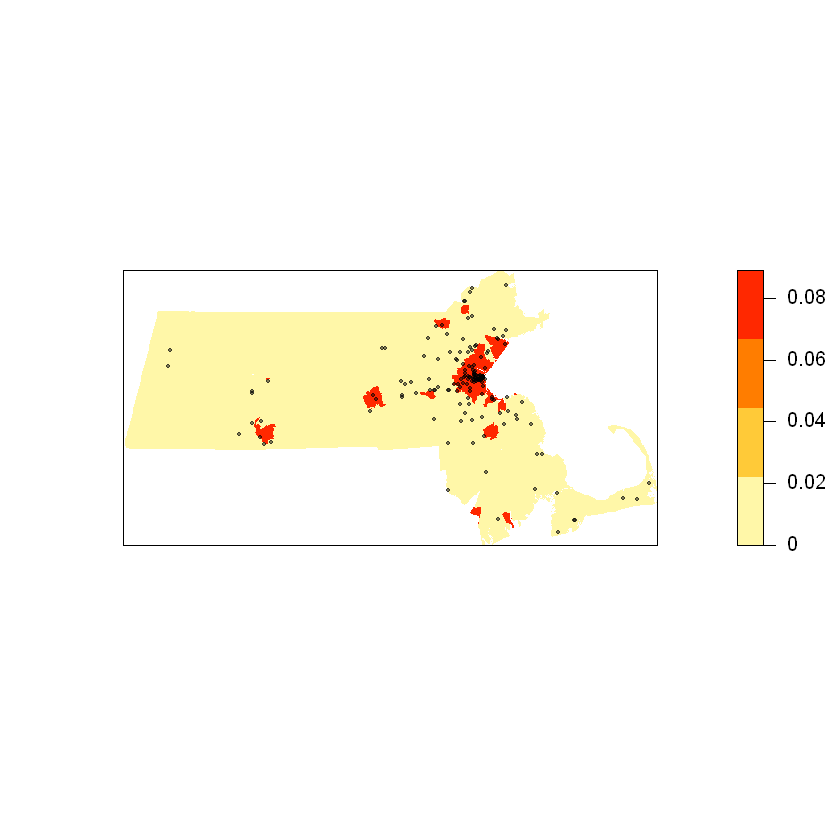

In [61]:
cl <-  interp.colours(c("lightyellow", "orange" ,"red"), E$n)
plot( intensity(Q, image=TRUE), las=1, col=cl, main=NULL)
plot(starbucks.km, pch=20, cex=0.6, col=rgb(0,0,0,.5), add=TRUE)

#### 2. 核密度（Kernel density）

##### 核密度估计算法：
- 原理：通过叠加核函数（如高斯核）估计概率密度，公式
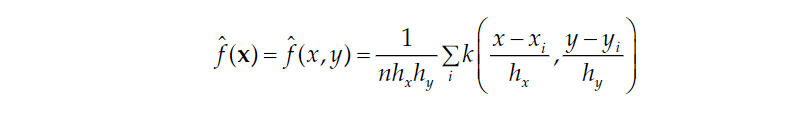
- 带宽选择：Bowman-Azzalini/Scott规则（基于标准差和样本量）:
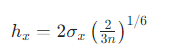

- 从左至右依次是原始数据点分布、较小带宽下的概率密度估计、较大带宽下的概率密度估计。通过原始数据点分布，可看到数据的实际分布情况。较小带宽下的估计结果紧密跟随数据点，形成多个尖锐的 “峰”，反映出数据的局部聚集特征；较大带宽下的估计结果则更为平滑，“峰” 的数量减少且更为宽阔，突出了数据分布的整体趋势，减少了局部波动的影响。
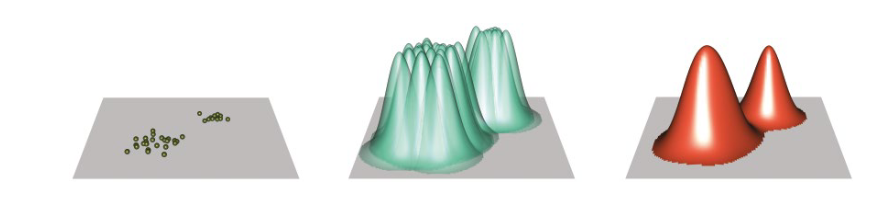
- 展示了不同带宽取值下的概率密度估计表面形态。从左至右，带宽逐渐增大。左侧图带宽小，概率密度估计呈现出多个尖锐的 “峰”，表明估计结果受单个观测点影响大，局部特征突出；中间图带宽适中，“峰” 变得平滑和宽阔，在一定程度上平衡了局部和整体特征；右侧图带宽大，“峰” 几乎消失，估计表面趋于平坦，此时更强调整体分布特征，局部特征被弱化。
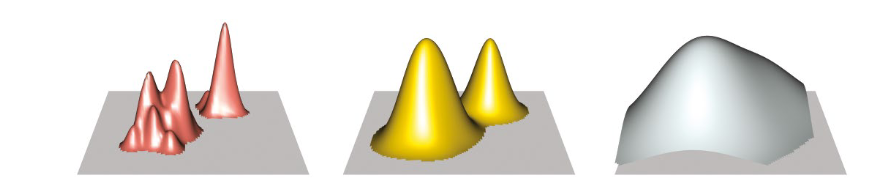

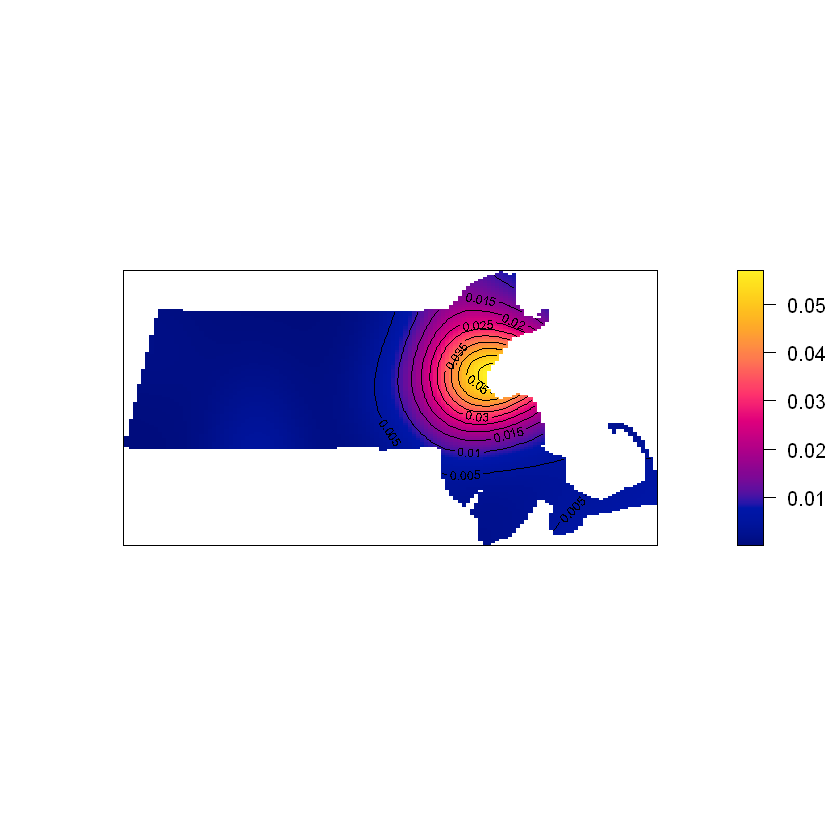

In [63]:
# spatstat 包有一个称为密度的函数，它计算点模式的各向同性内核强度估计。它的带宽定义了内核的窗口范围。下一个代码块使用默认带宽。
K1 <- density(starbucks.km) # Using the default bandwidth
plot(K1, main=NULL, las=1)
contour(K1, add=TRUE)

使用50公里带宽（sigma = 50）。

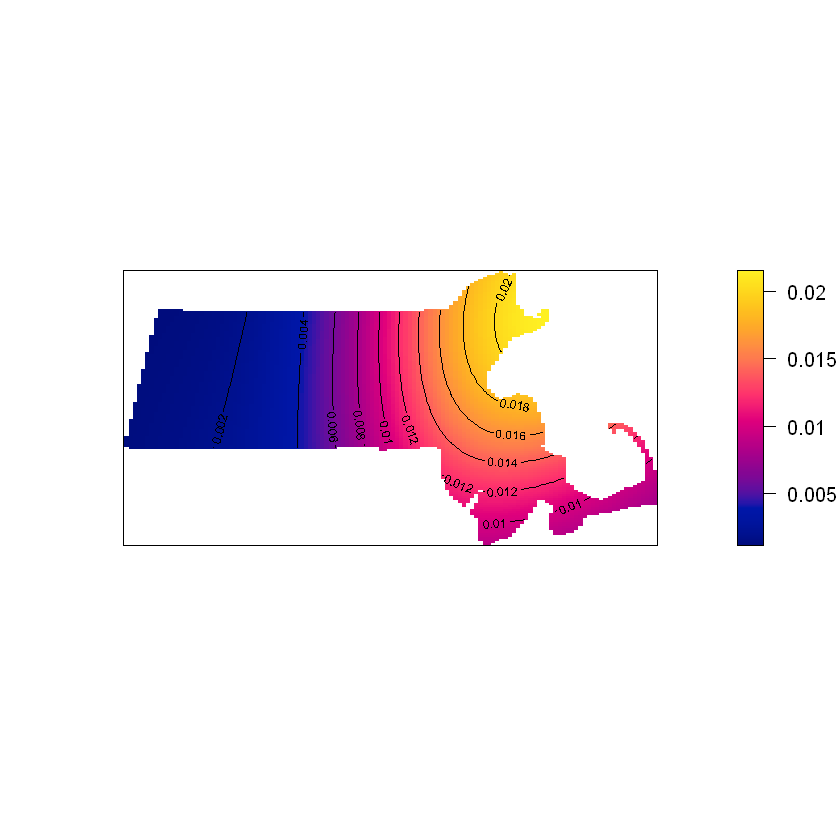

In [64]:
K2 <- density(starbucks.km, sigma=50) # Using a 50km bandwidth
plot(K2, main=NULL, las=1)
contour(K2, add=TRUE)

内核默认为高斯平滑函数。平滑函数可以转换为四次函数、圆盘函数或埃帕内尼科夫函数。例如，要将内核更改为磁盘函数类型：

#### 四次函数（Quartic Function）
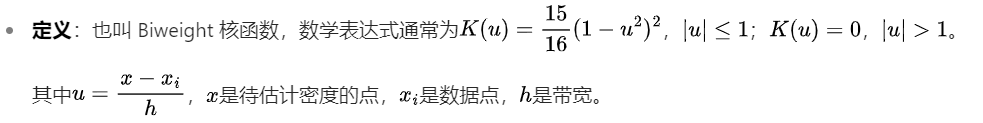
#### 圆盘函数（Disc Function）
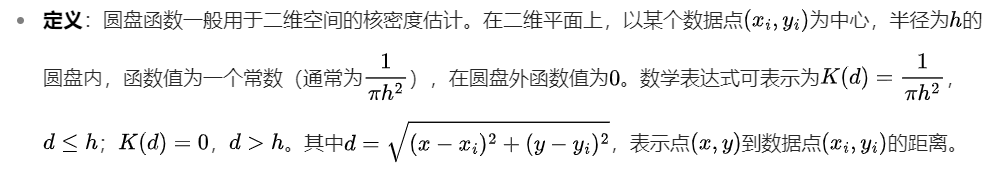
#### 埃帕内尼科夫函数（Epanechnikov Function）
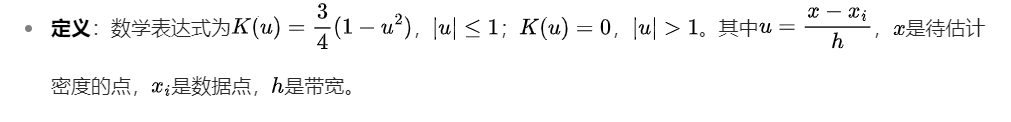


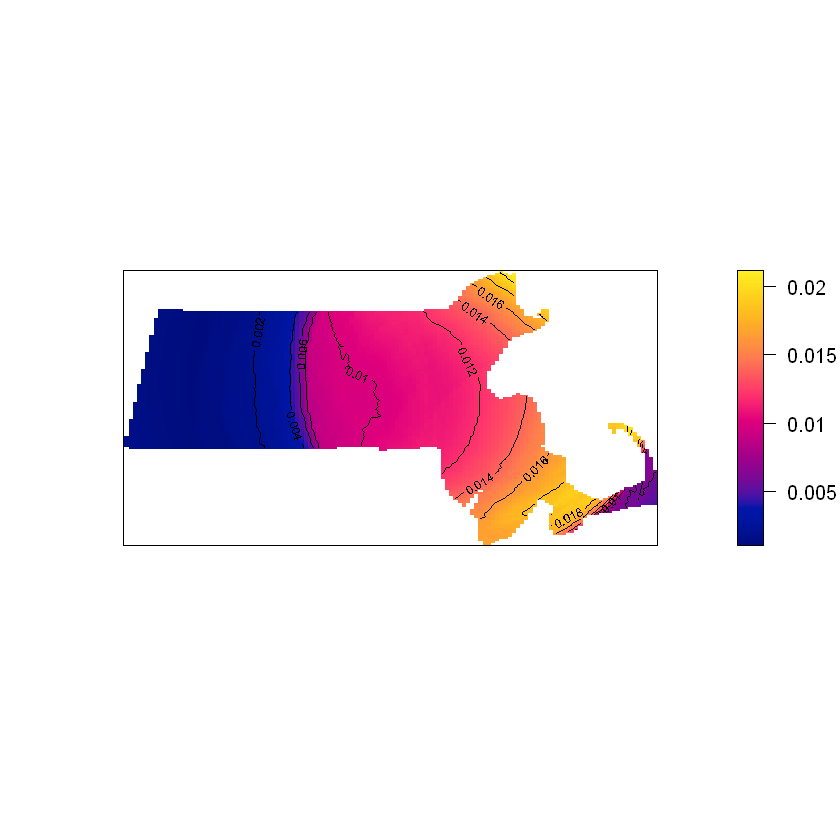

In [65]:
K3 <- density(starbucks.km, kernel = "disc", sigma=50) # Using a 50km bandwidth
plot(K3, main=NULL, las=1)
contour(K3, add=TRUE)

In [ ]:
https://mgimond.github.io/Spatial/point-pattern-analysis-in-r.html